### https://medium.com/@saidakbarp/interactive-map-visualization-with-folium-in-python-2e95544d8d9b

In [18]:
!pip install folium

     |████████████████████████████████| 91 kB 3.3 MB/s eta 0:00:011


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
import os
#print(os.listdir("../input"))
import warnings
warnings.filterwarnings("ignore")

In [7]:
hsales = pd.read_csv('input/nyc-rolling-sales.csv') 

In [8]:
hsales.shape

(84548, 22)

In [10]:
hsales.drop(['Unnamed: 0', 'EASE-MENT'],1, inplace=True)
# let's check what we have 
hsales.head()


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [11]:
# LAND SQUARE FEET,GROSS SQUARE FEET, SALE PRICE, BOROUGH should be numeric. 
# SALE DATE datetime format.
# categorical: NEIGHBORHOOD, BUILDING CLASS CATEGORY, TAX CLASS AT PRESENT, BUILDING CLASS AT PRESENT,
# BUILDING CLASS AT TIME OF SALE, TAX CLASS AT TIME OF SALE,BOROUGH 

numer = ['LAND SQUARE FEET','GROSS SQUARE FEET', 'SALE PRICE', 'BOROUGH']
for col in numer: # coerce for missing values
    hsales[col] = pd.to_numeric(hsales[col], errors='coerce')

categ = ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'TAX CLASS AT PRESENT', 'BUILDING CLASS AT PRESENT', 'BUILDING CLASS AT TIME OF SALE', 'TAX CLASS AT TIME OF SALE']
for col in categ:
    hsales[col] = hsales[col].astype('category')

hsales['SALE DATE'] = pd.to_datetime(hsales['SALE DATE'], errors='coerce')

In [12]:
missing = hsales.isnull().sum()/len(hsales)*100

print(pd.DataFrame([missing[missing>0],pd.Series(hsales.isnull().sum()[hsales.isnull().sum()>1000])], index=['percent missing','how many missing']))

                  LAND SQUARE FEET  GROSS SQUARE FEET   SALE PRICE
percent missing          31.049818          32.658372     17.22217
how many missing      26252.000000       27612.000000  14561.00000


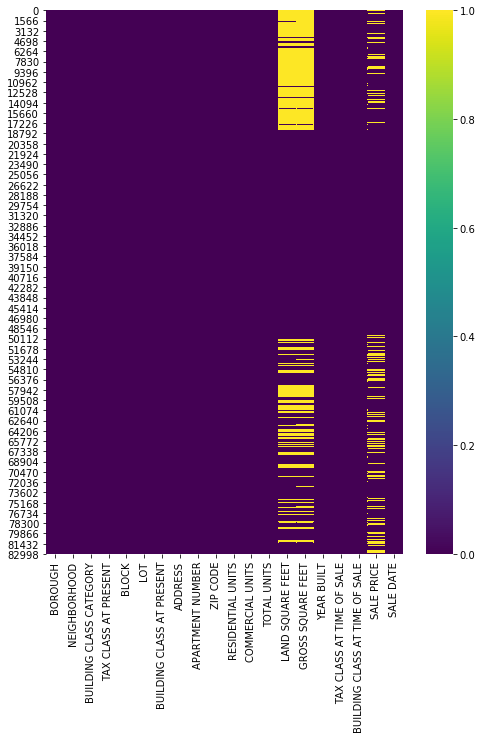

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.figure(figsize=(8,10))
sns.heatmap(hsales.isnull(),cmap='viridis')

In [14]:
missing = hsales.isnull().sum()/len(hsales)*100
print(pd.DataFrame([missing[missing>0],pd.Series(hsales.isnull().sum()[hsales.isnull().sum()>1000])], index=['percent missing','how many missing']))

                  LAND SQUARE FEET  GROSS SQUARE FEET   SALE PRICE
percent missing          31.049818          32.658372     17.22217
how many missing      26252.000000       27612.000000  14561.00000


In [15]:
# for visualization purposes, we replace borough numbering with their string names
hsales['BOROUGH'] = hsales['BOROUGH'].astype(str)
hsales['BOROUGH'] = hsales['BOROUGH'].str.replace("1", "Manhattan")
hsales['BOROUGH'] = hsales['BOROUGH'].str.replace("2", "Bronx")
hsales['BOROUGH'] = hsales['BOROUGH'].str.replace("3", "Brooklyn")
hsales['BOROUGH'] = hsales['BOROUGH'].str.replace("4", "Queens")
hsales['BOROUGH'] = hsales['BOROUGH'].str.replace("5", "Staten Island")

In [16]:
hsales['BOROUGH'].value_counts()

Queens           26736
Brooklyn         24047
Manhattan        18306
Staten Island     8410
Bronx             7049
Name: BOROUGH, dtype: int64

In [25]:
dataset = hsales[(hsales['COMMERCIAL UNITS']<20) & (hsales['TOTAL UNITS']<50) & (hsales['SALE PRICE']<5000000) & (hsales['SALE PRICE']>100000) & (hsales['GROSS SQUARE FEET']>0)]

In [26]:
zipcodes = dataset[hsales["ZIP CODE"]>0]
zipcodes['ZIP']=zipcodes['ZIP CODE'].astype(str) # zipcodes should be str type because geojson file zipcodes are read as str 

In [36]:
boroughs = zipcodes[['ZIP','BOROUGH']]
boroughs.drop_duplicates('ZIP', inplace=True)

In [34]:
us_zipcodes = pd.read_csv("input/uszipcodes_geodata.txt", delimiter=',', dtype=str)
zipcodes_agg = pd.merge(zipcodes.groupby('ZIP').agg(np.mean), us_zipcodes, how='left', on='ZIP')
zipcodes_agg = pd.merge(zipcodes_agg, boroughs, how='left', on='ZIP')
zipcodes_agg.loc[116,'LAT']="40.6933"
zipcodes_agg.loc[116,'LNG']="-73.9925"
#zipcodes_agg

In [44]:
zipcodes_agg.head()

,ZIP,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,LAT,LNG,BOROUGH
0,10001,795.666667,48.000000,10001.0,0.000000,6.666667,6.666667,3417.333333,29501.666667,1909.333333,3.056667e+06,40.750633,-73.997177,Manhattan
1,10002,303.750000,27.750000,10002.0,9.000000,1.500000,10.500000,2362.250000,8595.500000,1923.250000,4.012500e+06,40.715775,-73.986212,Manhattan
2,10003,716.428571,24.142857,10003.0,6.142857,0.714286,6.857143,2665.142857,12814.857143,1904.142857,3.128165e+06,40.731829,-73.989181,Manhattan
3,10009,403.166667,18.666667,10009.0,4.666667,0.666667,5.333333,1623.166667,4173.166667,1908.666667,3.646519e+06,40.726399,-73.978631,Manhattan
4,10010,882.000000,14.000000,10010.0,2.000000,0.000000,2.000000,1407.000000,3080.000000,1910.000000,3.700000e+06,40.739065,-73.982255,Manhattan


In [41]:
map.choropleth(geo_data="input/nyc-zip-code-tabulation-areas-polygons.geojson",
               data=zipcodes_agg,                      # my dataset
               columns=['ZIP', 'SALE PRICE'],          # zip code is here for matching the geojson zipcode, sales price is the column that changes the color of zipcode areas
               key_on='feature.properties.postalCode', # this path contains zipcodes in str type, this zipcodes should match with our ZIP CODE column
               fill_color='BuPu', fill_opacity=0.7, line_opacity=0.2,
               legend_name='SALE PRICE')

# add a marker for every record in the filtered data, use a clustered view
marker_cluster = MarkerCluster().add_to(map) # create marker clusters

for i in range(zipcodes_agg.shape[0]):
    location = [zipcodes_agg['LAT'][i],zipcodes_agg['LNG'][i]]
    tooltip = "Zipcode:{}<br> Borough: {}<br> Click for more".format(zipcodes_agg["ZIP"][i], zipcodes_agg['BOROUGH'][i])
    
    folium.Marker(location, # adding more details to the popup screen using HTML
                  popup="""
                  <i>Mean sales price: </i> <br> <b>${}</b> <br> 
                  <i>mean total units: </i><b><br>{}</b><br>
                  <i>mean square feet: </i><b><br>{}</b><br>""".format(
                    round(zipcodes_agg['SALE PRICE'][i],2), 
                    round(zipcodes_agg['TOTAL UNITS'][i],2), 
                    round(zipcodes_agg['GROSS SQUARE FEET'][i],2)), 
                  tooltip=tooltip).add_to(marker_cluster)
map